In [100]:
from IPython.display import clear_output
!pip install fancyimpute
!pip install statsmodels miceforest
!pip install h2o
clear_output()

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import h2o
from h2o.automl import H2OAutoML
from fancyimpute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import models, Sequential, layers, Model, metrics


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
TRAIN_PATH = '/content/drive/MyDrive/Spaceship-titanic/train.csv'
TEST_PATH = '/content/drive/MyDrive/Spaceship-titanic/test.csv'
TARGET_CLASS = 'Transported'

In [6]:
#functions

def missing_value(df):
      missing_values = df.isna().sum().to_frame()
      missing_values = missing_values.rename(columns= {0: 'missing_values'})
      missing_values['% of total'] = (missing_values['missing_values'] / df.shape[0]).round(2)*100
      return missing_values

In [7]:
df = pd.read_csv(TRAIN_PATH)

In [8]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
#missing column
missing = missing_value(df)
missing

,missing_values,% of total
PassengerId,0,0.0
HomePlanet,201,2.0
CryoSleep,217,2.0
Cabin,199,2.0
Destination,182,2.0
Age,179,2.0
VIP,203,2.0
RoomService,181,2.0
FoodCourt,183,2.0
ShoppingMall,208,2.0


In [ ]:
fig = px.bar(x=missing.index, y='missing_values', data_frame=missing)
fig.update_layout(width=800, height=600)
fig.show()

In [ ]:
#replace null values in the dataframe

for col in df.columns:
  if df[str(col)].dtypes == 'object':
    df[str(col)].fillna(df[str(col)].mode()[0], inplace=True)
  elif df[str(col)].dtypes == 'float64':
    df[str(col)].fillna(df[str(col)].mean().round(0), inplace=True)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(3), float64(6), object(5)
memory usage: 772.6+ KB


In [11]:
#create categorical column for age

map_age = {'Children': range(0,13),
           'Teenagers': range(13,18),
           'young Adult': range(18,30),
           'Middle Age': range(30,50),
           'Elderly' : range(50,100)
           }

df['Age_category'] = df['Age'].apply(lambda x:next((k for k, v in map_age.items() if x in v), 'unknown'))

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [12]:
df['Cabin'].value_counts

<bound method IndexOpsMixin.value_counts of 0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object>

In [13]:
df[['Deck', 'Cabin_num', 'side']] = df['Cabin'].str.split('/', expand=True)

In [14]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_category,Deck,Cabin_num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Middle Age,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,young Adult,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Elderly,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Middle Age,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Teenagers,F,1,S


In [15]:
df['Age'].value_counts()

24.0    324
18.0    320
21.0    311
19.0    293
23.0    292
       ... 
72.0      4
78.0      3
79.0      3
76.0      2
77.0      2
Name: Age, Length: 80, dtype: int64

In [16]:
df['Spa']

0          0.0
1        549.0
2       6715.0
3       3329.0
4        565.0
         ...  
8688    1643.0
8689       0.0
8690       1.0
8691     353.0
8692       0.0
Name: Spa, Length: 8693, dtype: float64

In [17]:
#replace bool with 1, 0 
bool_column = df.select_dtypes(include='bool').columns

df[bool_column] = df[bool_column].replace([True, False],[1, 0])

In [18]:
drop_data = []
for col in df.columns:
  if len(df[str(col)].unique())/len(df[str(col)]) > 0.2:
    drop_data.append(col)

In [19]:
drop_data.append('Age')

In [20]:
df_clean = df.drop(columns=drop_data, axis=1)
df_clean.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Age_category,Deck,side
0,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,0,Middle Age,B,P
1,Earth,False,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,1,young Adult,F,S
2,Europa,False,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,0,Elderly,A,S
3,Europa,False,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,0,Middle Age,A,S
4,Earth,False,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,1,Teenagers,F,S


In [21]:
object_column = df_clean.select_dtypes(include='object').columns.to_list()

In [22]:
df_clean1 = pd.get_dummies(df_clean, columns=object_column)

In [23]:
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RoomService                8512 non-null   float64
 1   FoodCourt                  8510 non-null   float64
 2   ShoppingMall               8485 non-null   float64
 3   Spa                        8510 non-null   float64
 4   VRDeck                     8505 non-null   float64
 5   Transported                8693 non-null   int64  
 6   HomePlanet_Earth           8693 non-null   uint8  
 7   HomePlanet_Europa          8693 non-null   uint8  
 8   HomePlanet_Mars            8693 non-null   uint8  
 9   CryoSleep_False            8693 non-null   uint8  
 10  CryoSleep_True             8693 non-null   uint8  
 11  Destination_55 Cancri e    8693 non-null   uint8  
 12  Destination_PSO J318.5-22  8693 non-null   uint8  
 13  Destination_TRAPPIST-1e    8693 non-null   uint8

# Mice 

In [28]:
mice_imputer = IterativeImputer()
df_column = df_clean1.columns
X_imputed = mice_imputer.fit_transform(df_clean1)

In [29]:
X_imputed

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.090e+02, 9.000e+00, 2.500e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [4.300e+01, 3.576e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 1.872e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [0.000e+00, 1.049e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.260e+02, 4.688e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00]])

In [33]:
df_imputed = pd.DataFrame(X_imputed)
df_imputed.columns = df_column
df_imputed.head()
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RoomService                8693 non-null   float64
 1   FoodCourt                  8693 non-null   float64
 2   ShoppingMall               8693 non-null   float64
 3   Spa                        8693 non-null   float64
 4   VRDeck                     8693 non-null   float64
 5   Transported                8693 non-null   float64
 6   HomePlanet_Earth           8693 non-null   float64
 7   HomePlanet_Europa          8693 non-null   float64
 8   HomePlanet_Mars            8693 non-null   float64
 9   CryoSleep_False            8693 non-null   float64
 10  CryoSleep_True             8693 non-null   float64
 11  Destination_55 Cancri e    8693 non-null   float64
 12  Destination_PSO J318.5-22  8693 non-null   float64
 13  Destination_TRAPPIST-1e    8693 non-null   float

In [ ]:
df_clean1.corr()['Transported']

CryoSleep                    0.460132
VIP                         -0.037261
RoomService                 -0.242049
FoodCourt                    0.046074
ShoppingMall                 0.010020
Spa                         -0.218791
VRDeck                      -0.204825
Transported                  1.000000
HomePlanet_Earth            -0.168845
HomePlanet_Europa            0.176916
HomePlanet_Mars              0.019544
Destination_55 Cancri e      0.108722
Destination_PSO J318.5-22    0.000092
Destination_TRAPPIST-1e     -0.096319
Age_category_Children        0.125399
Age_category_Elderly        -0.011422
Age_category_Middle Age     -0.036782
Age_category_Teenagers       0.030376
Age_category_young Adult    -0.049551
Deck_A                      -0.002623
Deck_B                       0.144733
Deck_C                       0.108193
Deck_D                      -0.034046
Deck_E                      -0.097965
Deck_F                      -0.087753
Deck_G                       0.015822
Deck_T      

In [ ]:
for col in df_clean1.columns:
  fig = px.bar(df_clean1, x=str(col), color='Transported')
  fig.update_layout(width=800, height=600)
  fig.show()

# KNN

In [87]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(df_imputed.drop('Transported', axis=1))
y = kmeans.labels_


In [88]:
pd.Series(y)

0       1
1       1
2       0
3       1
4       1
       ..
8688    0
8689    1
8690    1
8691    1
8692    0
Length: 8693, dtype: int32

In [89]:
df_imputed['knn_class'] = pd.Series(y)

In [90]:
df_imputed

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,side_P,side_S,knn_class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,109.0,9.0,25.0,549.0,44.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2,43.0,3576.0,0.0,6715.0,49.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.0,1283.0,371.0,3329.0,193.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,303.0,70.0,151.0,565.0,2.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8689,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
8690,0.0,0.0,1872.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
8691,0.0,1049.0,0.0,353.0,3235.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1


# Pca

In [91]:
#visualise dataset in 3d space with pca

X = df_imputed.drop('Transported', axis=1)
y = df_imputed['Transported']

n_components = 3
pca  = PCA(n_components=n_components)

x_pca = pca.fit_transform(X)
a = pca.explained_variance_ratio_
n = 1
for i in a:
  print(f'Explained variance of component {n} {i.round(2)*100}')
  n+=1


df_pca = pd.DataFrame(x_pca, columns=['comp_1', 'comp_2', 'comp_3'])
df_pca['Transported'] = y

df_pca


Explained variance of component 1 47.0
Explained variance of component 2 21.0
Explained variance of component 3 18.0


,comp_1,comp_2,comp_3,Transported
0,-590.557281,-217.129275,-23.889946,0.0
1,-418.682737,155.579006,346.495719,1.0
2,4558.108497,2624.223784,4802.370940,0.0
3,1560.317506,1503.123478,2258.130817,0.0
4,-372.697645,114.931734,394.051460,1.0
...,...,...,...,...
8688,6133.882150,-1859.982877,1109.662799,0.0
8689,-590.557715,-217.129585,-23.889979,0.0
8690,-599.127568,-198.436565,6.315686,1.0
8691,1404.243959,1734.111691,-1998.477747,0.0


In [92]:
a = pca.explained_variance_ratio_
n = 1
for i in a:
  print(f'Explained variance of  component{n} {i.round(2)*100}')
  n+=1


Explained variance of  component1 47.0
Explained variance of  component2 21.0
Explained variance of  component3 18.0


In [93]:
fig = px.scatter_3d(df_pca, x='comp_1', y='comp_2', z='comp_3', color='Transported', title='visualisation of Dataset in 3d space')
fig.show()

In [94]:
X = df_imputed.drop('Transported', axis=1)
y = df_imputed['Transported']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [95]:
def model():
    model = Sequential(layers=[
        layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
        layers.Normalization(name='normalisation'),
        layers.Dense(256, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout'),
        layers.Dense(512, activation='relu', name='dense2'),
        layers.Dropout(0.3, name='dropout2'),
        layers.Dense(1024, activation='relu', name='dense3'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    )
    return model


In [96]:
model = model()

In [97]:
EPOCHS = 50
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [98]:
model.compile(optimizer=optimizer,
            loss='binary_crossentropy', metrics=['accuracy', 'Precision'])

In [99]:
history = model.fit(
    x_train_scaled, y_train, 
    validation_data=(x_test_scaled, y_test), 
    epochs=EPOCHS,
    batch_size=256
    )

Epoch 1/50
24/24 [==============================] - 3s 78ms/step - loss: 0.5162 - accuracy: 0.7357 - precision: 0.7548 - val_loss: 0.4197 - val_accuracy: 0.7945 - val_precision: 0.8120
Epoch 2/50
24/24 [==============================] - 2s 75ms/step - loss: 0.4507 - accuracy: 0.7809 - precision: 0.7932 - val_loss: 0.4063 - val_accuracy: 0.8041 - val_precision: 0.7804
Epoch 3/50
24/24 [==============================] - 2s 70ms/step - loss: 0.4351 - accuracy: 0.7834 - precision: 0.8042 - val_loss: 0.4015 - val_accuracy: 0.8006 - val_precision: 0.7798
Epoch 4/50
24/24 [==============================] - 1s 44ms/step - loss: 0.4205 - accuracy: 0.7928 - precision: 0.7969 - val_loss: 0.3946 - val_accuracy: 0.8056 - val_precision: 0.7985
Epoch 5/50
24/24 [==============================] - 1s 40ms/step - loss: 0.4155 - accuracy: 0.7957 - precision: 0.8031 - val_loss: 0.3944 - val_accuracy: 0.8048 - val_precision: 0.7851
Epoch 6/50
24/24 [==============================] - 1s 40ms/step - loss: 0.

In [ ]:
kmeans = 

In [85]:
fig = px.scatter_3d(df_pca, x='comp_1', y='comp_2', z='comp_3', color='knn_class', title='visualisation of Dataset in 3d space')
fig.show()

In [77]:
X = df_pca.drop('Transported', axis=1)
y = df_pca['Transported']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [78]:
def model():
    model = Sequential(layers=[
        layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
        layers.Normalization(name='normalisation'),
        layers.Dense(256, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout'),
        layers.Dense(512, activation='relu', name='dense2'),
        layers.Dropout(0.3, name='dropout2'),
        layers.Dense(1024, activation='relu', name='dense3'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    )
    return model


In [79]:
model = model()

In [80]:
EPOCHS = 50
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [81]:
model.compile(optimizer=optimizer,
            loss='binary_crossentropy', metrics=['accuracy', 'Precision'])

In [82]:
history = model.fit(
    x_train_scaled, y_train, 
    validation_data=(x_test_scaled, y_test), 
    epochs=EPOCHS,
    batch_size=256
    )

Epoch 1/50
24/24 [==============================] - 4s 92ms/step - loss: 0.6016 - accuracy: 0.6896 - precision: 0.6387 - val_loss: 0.5600 - val_accuracy: 0.7063 - val_precision: 0.6487
Epoch 2/50
24/24 [==============================] - 1s 53ms/step - loss: 0.5715 - accuracy: 0.7035 - precision: 0.6532 - val_loss: 0.5471 - val_accuracy: 0.7159 - val_precision: 0.6682
Epoch 3/50
24/24 [==============================] - 2s 70ms/step - loss: 0.5595 - accuracy: 0.7141 - precision: 0.6704 - val_loss: 0.5499 - val_accuracy: 0.7086 - val_precision: 0.6581
Epoch 4/50
24/24 [==============================] - 2s 75ms/step - loss: 0.5495 - accuracy: 0.7185 - precision: 0.6779 - val_loss: 0.5330 - val_accuracy: 0.7247 - val_precision: 0.6858
Epoch 5/50
24/24 [==============================] - 1s 55ms/step - loss: 0.5438 - accuracy: 0.7257 - precision: 0.6906 - val_loss: 0.5281 - val_accuracy: 0.7347 - val_precision: 0.7066
Epoch 6/50
24/24 [==============================] - 1s 42ms/step - loss: 0.

In [102]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.19" 2023-04-18; OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphf490noa
  JVM stdout: /tmp/tmphf490noa/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphf490noa/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_unknownUser_nlu8gv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [123]:
df_h2o = h2o.import_file(TRAIN_PATH)

response = "Transported"

predictors = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name']

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [124]:
df_h2o['Transported'] = df_h2o['Transported'].asfactor()

In [125]:
train , test = df_h2o.split_frame(seed=42)

In [126]:
aml = H2OAutoML(max_runtime_secs=120, seed=1)
aml.train(x=predictors, y=response, training_frame=train)

AutoML progress: |
17:01:29.126: _train param, Dropping bad and constant columns: [PassengerId, Name]

██████████
17:01:48.721: _train param, Dropping bad and constant columns: [PassengerId, Name]

████████████████
17:02:19.533: _train param, Dropping bad and constant columns: [PassengerId, Name]

█████████████
17:02:44.610: _train param, Dropping unused columns: [PassengerId, Name]

██
17:02:47.79: _train param, Dropping bad and constant columns: [PassengerId, Name]

███
17:02:54.213: _train param, Dropping bad and constant columns: [PassengerId, Name]

████
17:03:00.546: _train param, Dropping bad and constant columns: [PassengerId, Name]

███
17:03:07.683: _train param, Dropping bad and constant columns: [PassengerId, Name]

████
17:03:14.40: _train param, Dropping bad and constant columns: [PassengerId, Name]

███
17:03:20.725: _train param, Dropping unused columns: [PassengerId, Name]

██
17:03:24.115: _train param, Dropping unused columns: [PassengerId, Name]

██
17:03:27.205: _t

key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/8
# GBM base models (used / total),4/4
# XGBoost base models (used / total),2/2
# GLM base models (used / total),1/1
# DRF base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [119]:
df1 =pd.read_csv(TRAIN_PATH)


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_1_AutoML_1_20230531_170128,0.875048,0.442354,0.884473,0.214216,0.38023,0.144575,2442,0.0932,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20230531_170128,0.87454,0.440616,0.884127,0.215138,0.379829,0.14427,3369,0.192618,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20230531_170128,0.874112,0.439684,0.884263,0.209878,0.379726,0.144192,3064,0.124859,StackedEnsemble
GBM_1_AutoML_1_20230531_170128,0.866908,0.457988,0.872654,0.220034,0.386076,0.149054,6166,0.117774,GBM
GBM_3_AutoML_1_20230531_170128,0.865887,0.466497,0.87317,0.211232,0.388182,0.150685,957,0.069012,GBM
GBM_2_AutoML_1_20230531_170128,0.861747,0.497959,0.871848,0.217242,0.400931,0.160746,1076,0.036839,GBM
XGBoost_2_AutoML_1_20230531_170128,0.860017,0.466194,0.870124,0.228467,0.390621,0.152585,795,0.016142,XGBoost
XGBoost_1_AutoML_1_20230531_170128,0.859587,0.471545,0.871617,0.221802,0.392043,0.153698,2165,0.030258,XGBoost
GBM_4_AutoML_1_20230531_170128,0.85765,0.503454,0.865728,0.208447,0.403083,0.162476,1063,0.05252,GBM
GLM_1_AutoML_1_20230531_170128,0.855296,0.474503,0.864919,0.232575,0.396854,0.157493,1247,0.023803,GLM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20230531_170128

,False,True,Error,Rate
False,763.0,314.0,0.2916,(314.0/1077.0)
True,140.0,952.0,0.1282,(140.0/1092.0)
Total,903.0,1266.0,0.2093,(454.0/2169.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

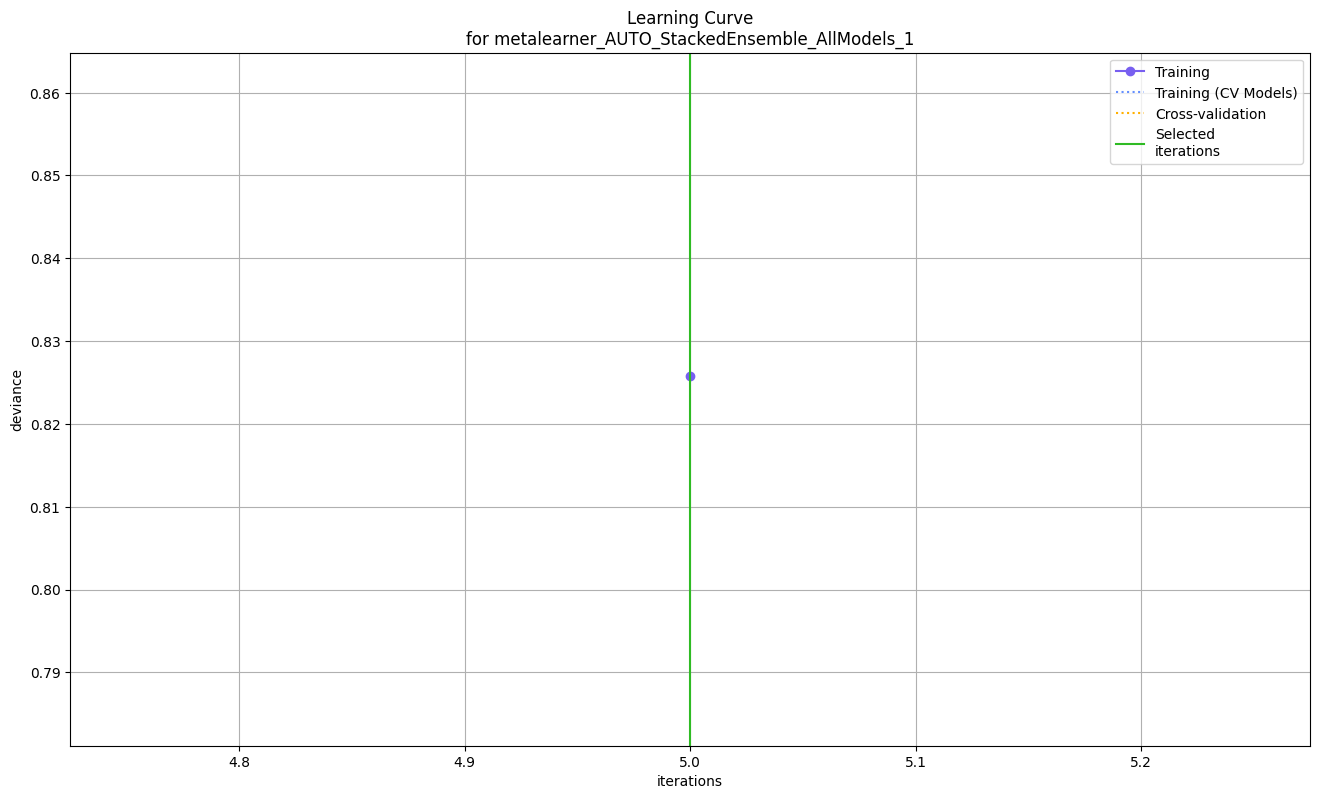

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

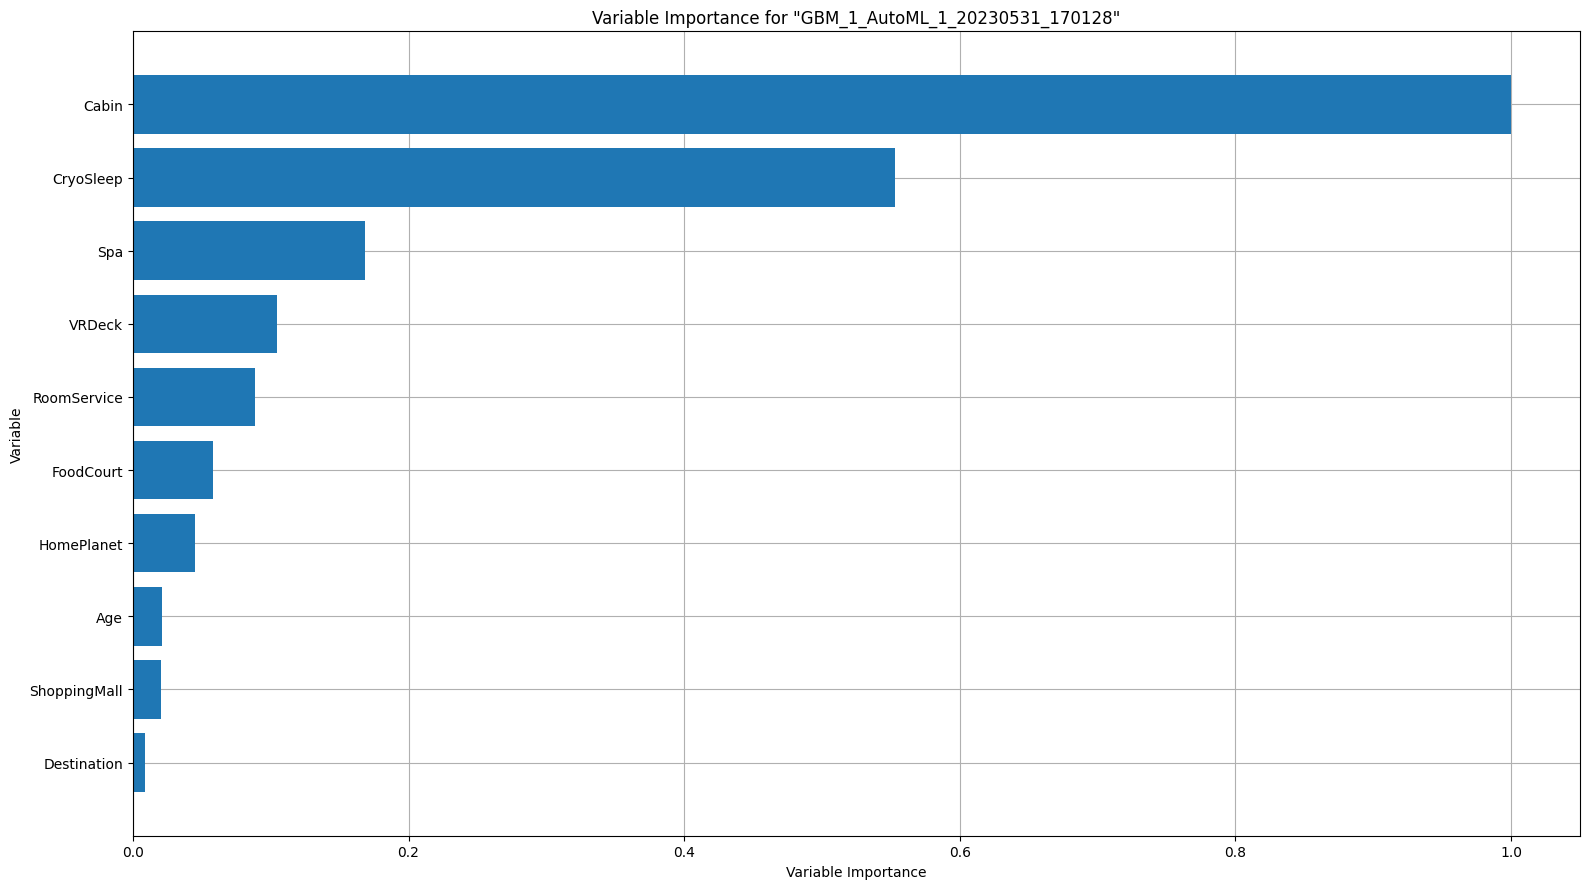

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

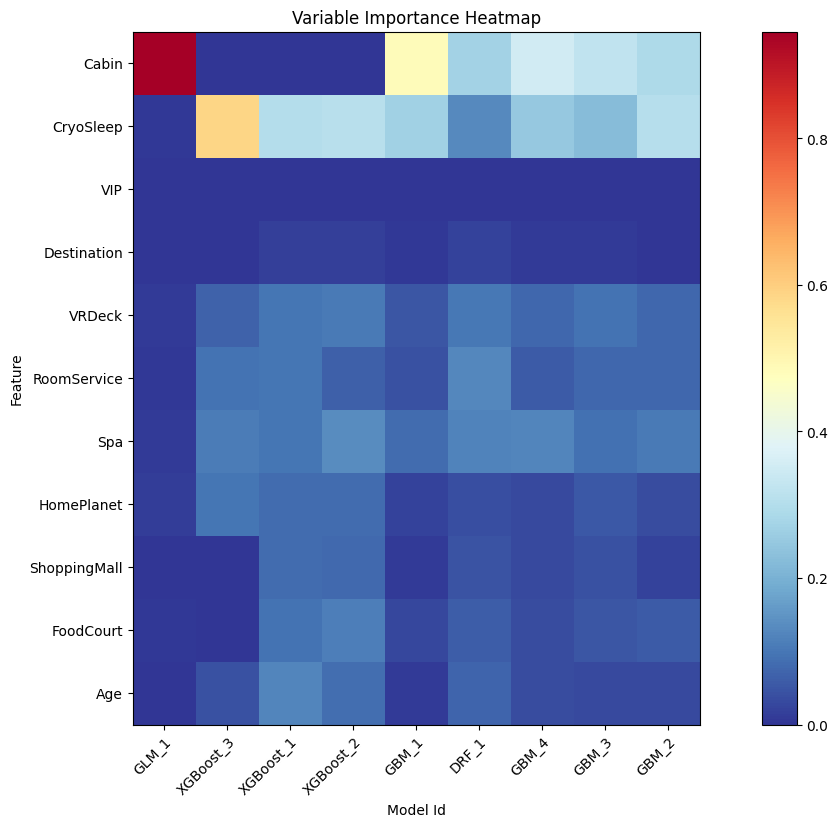

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

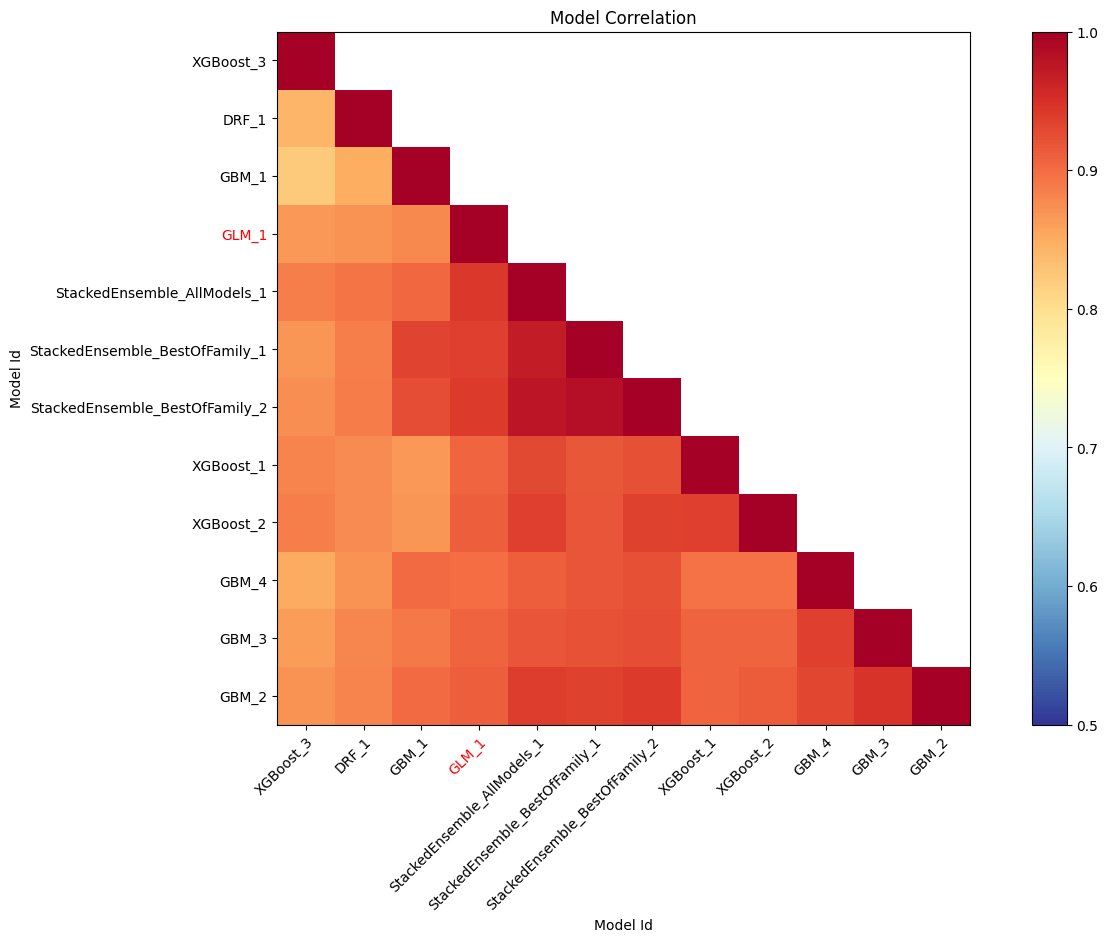

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

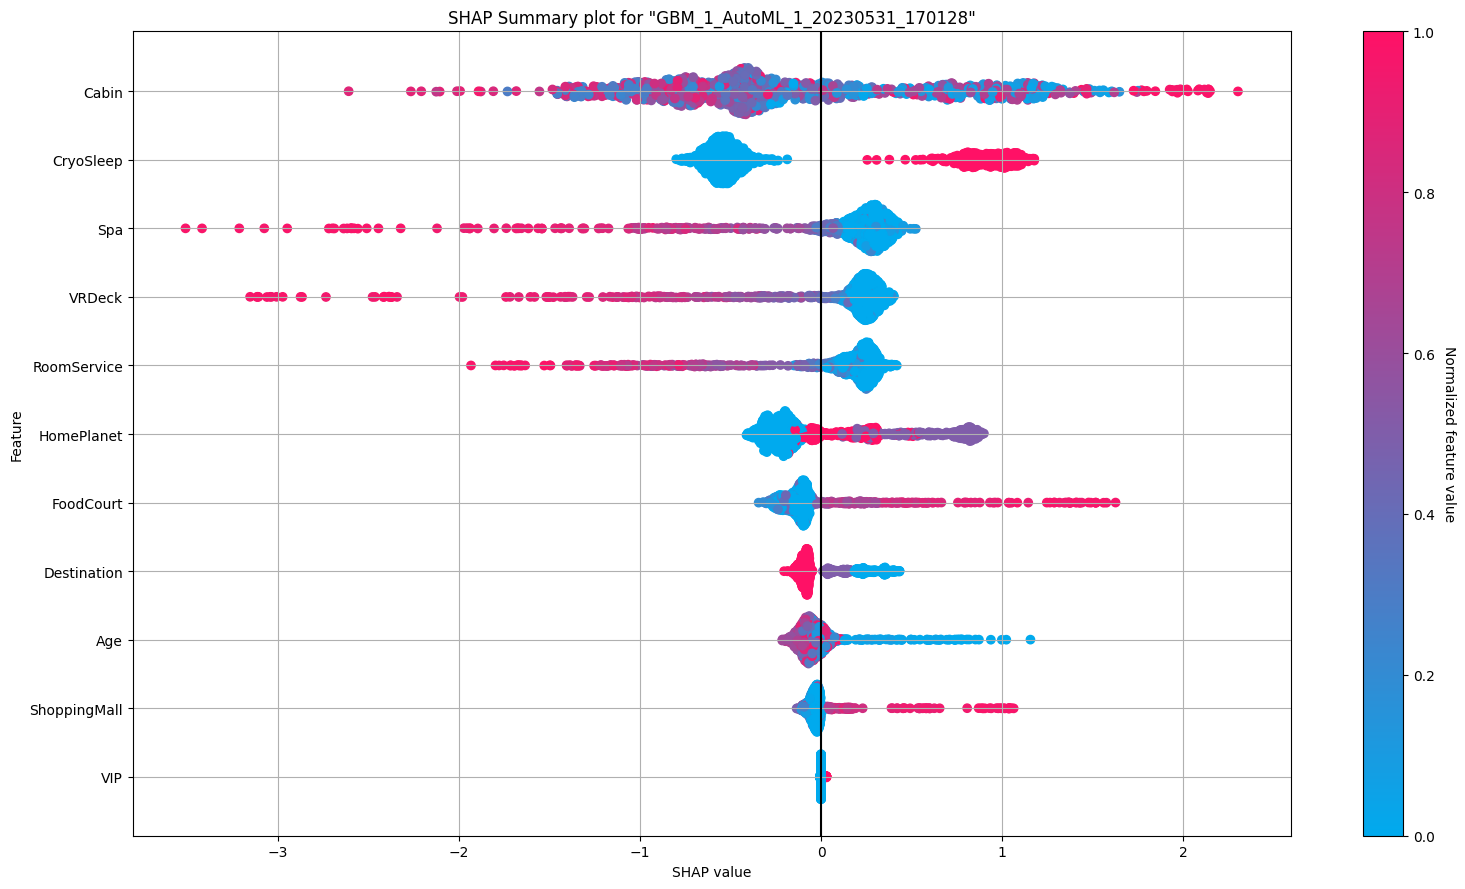

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

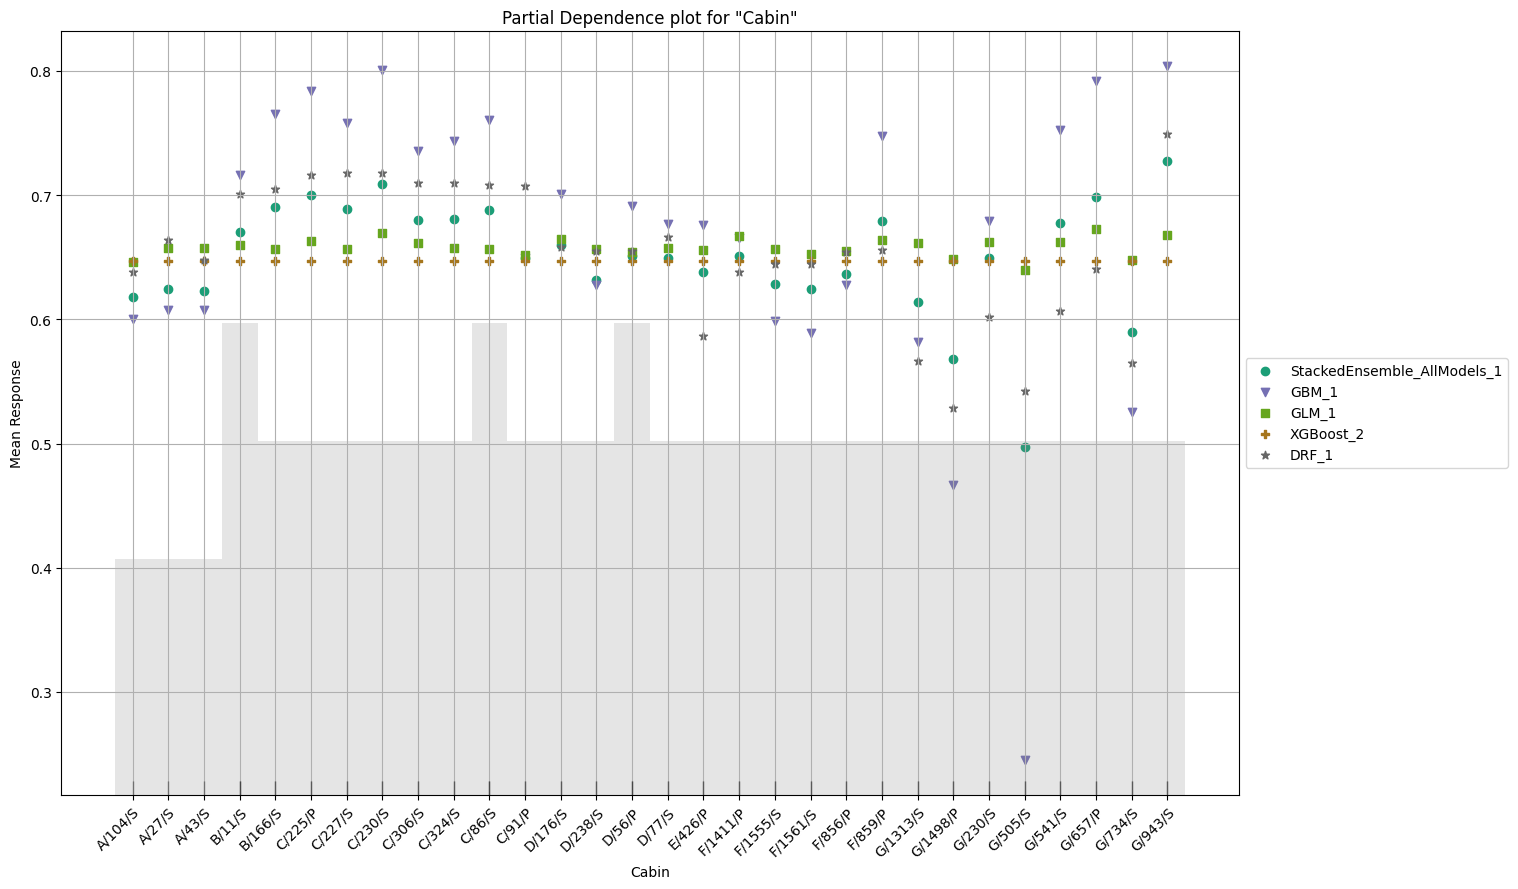

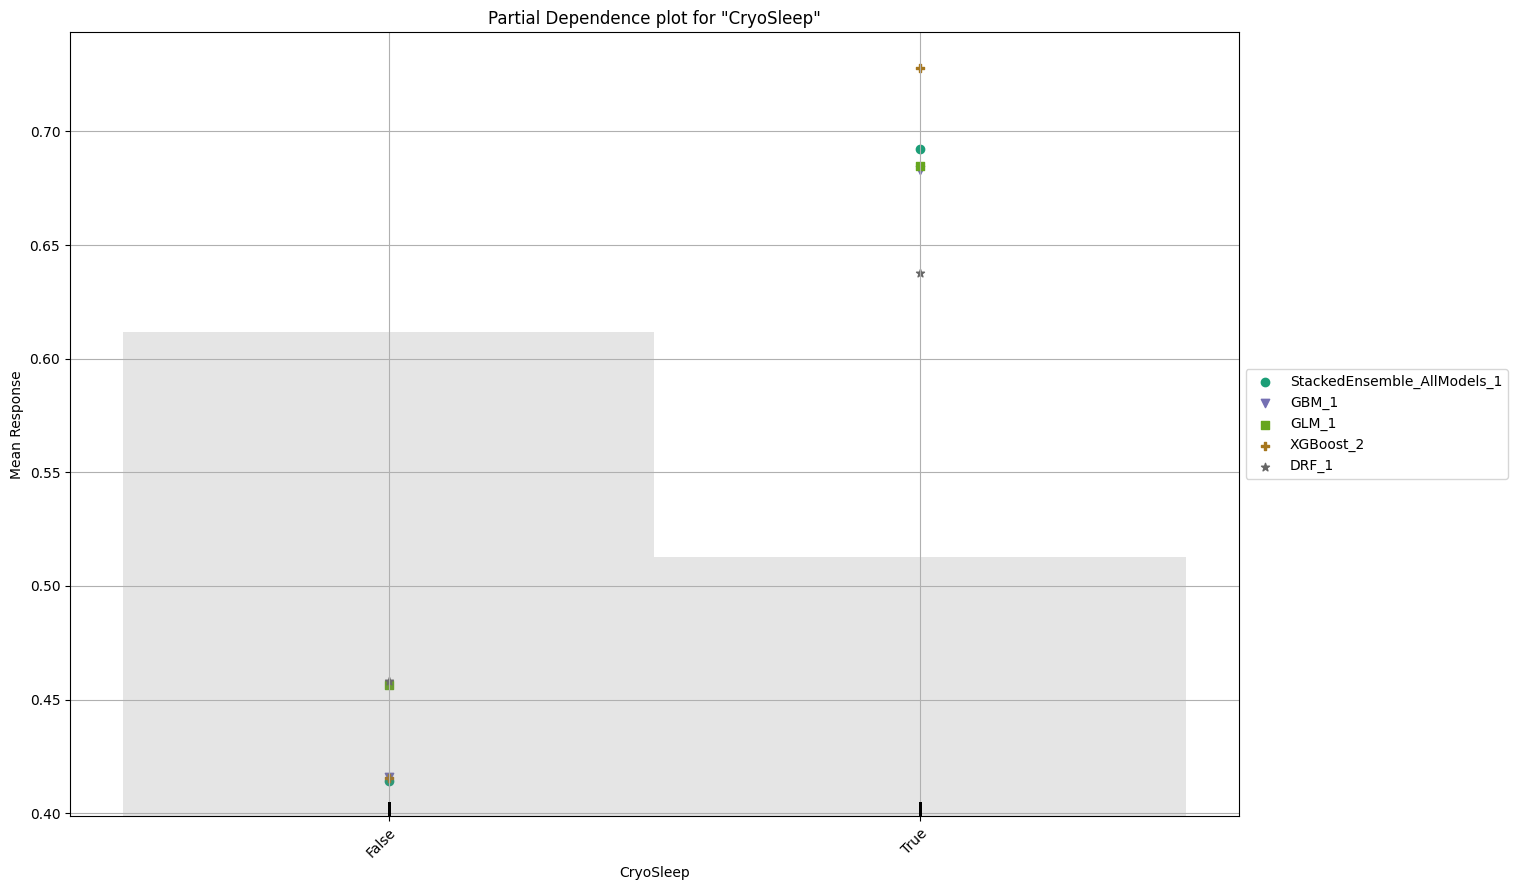

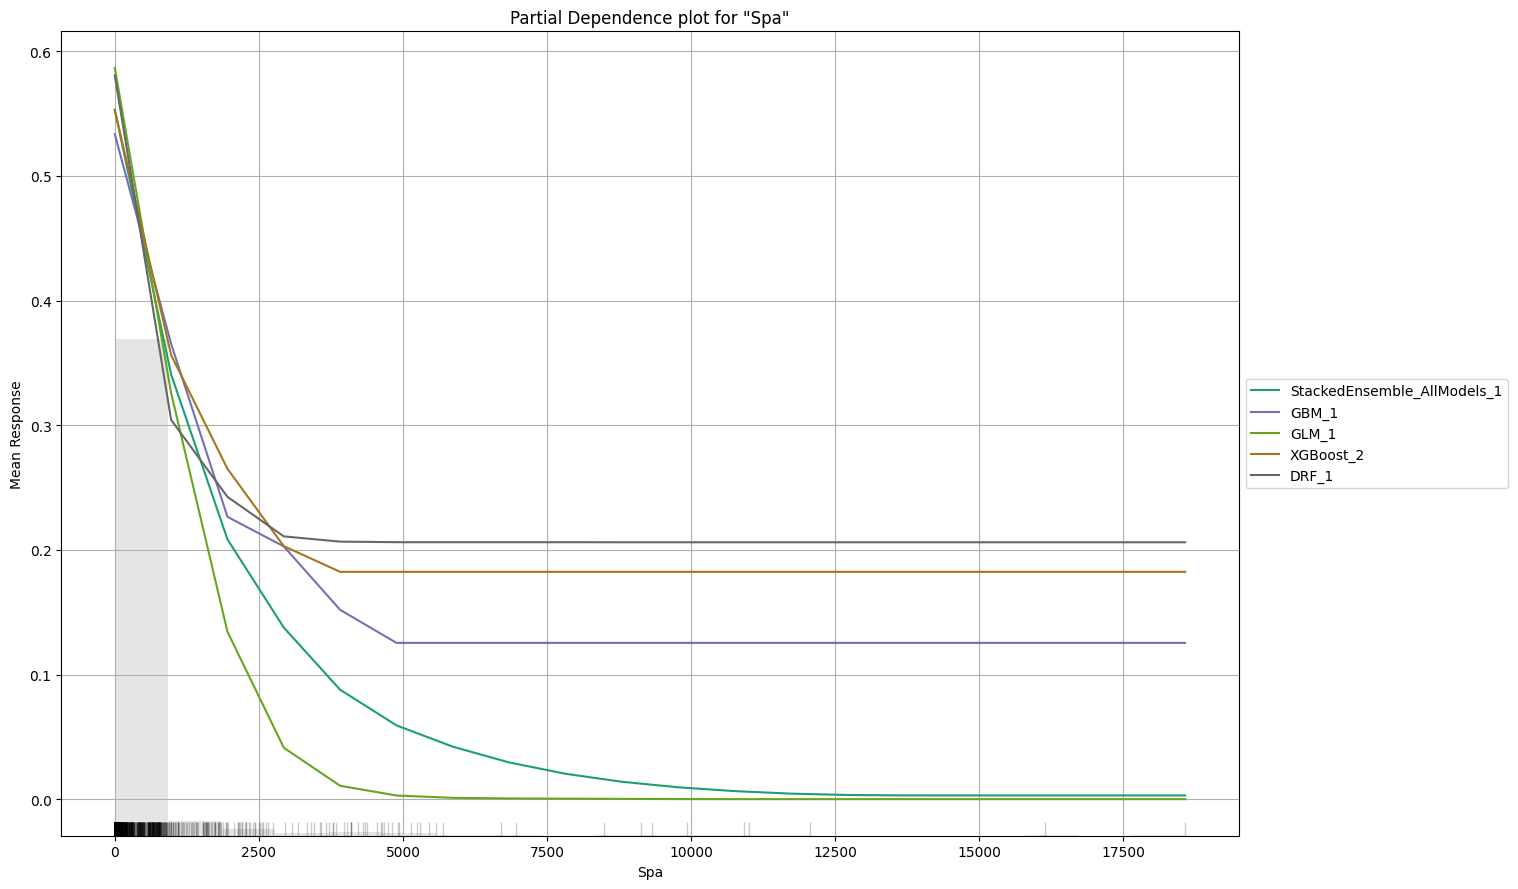

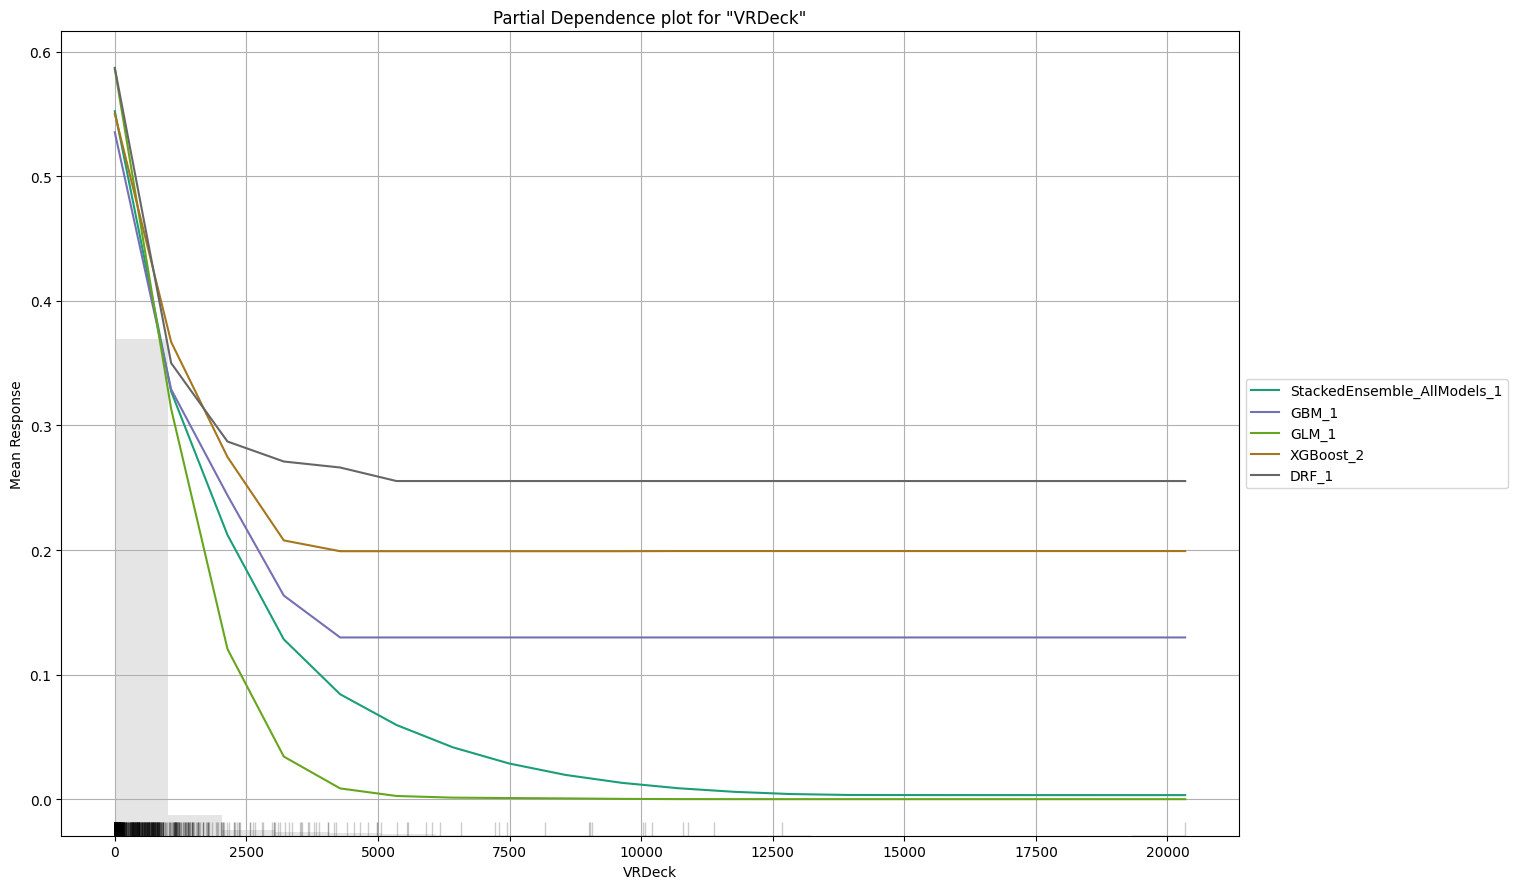

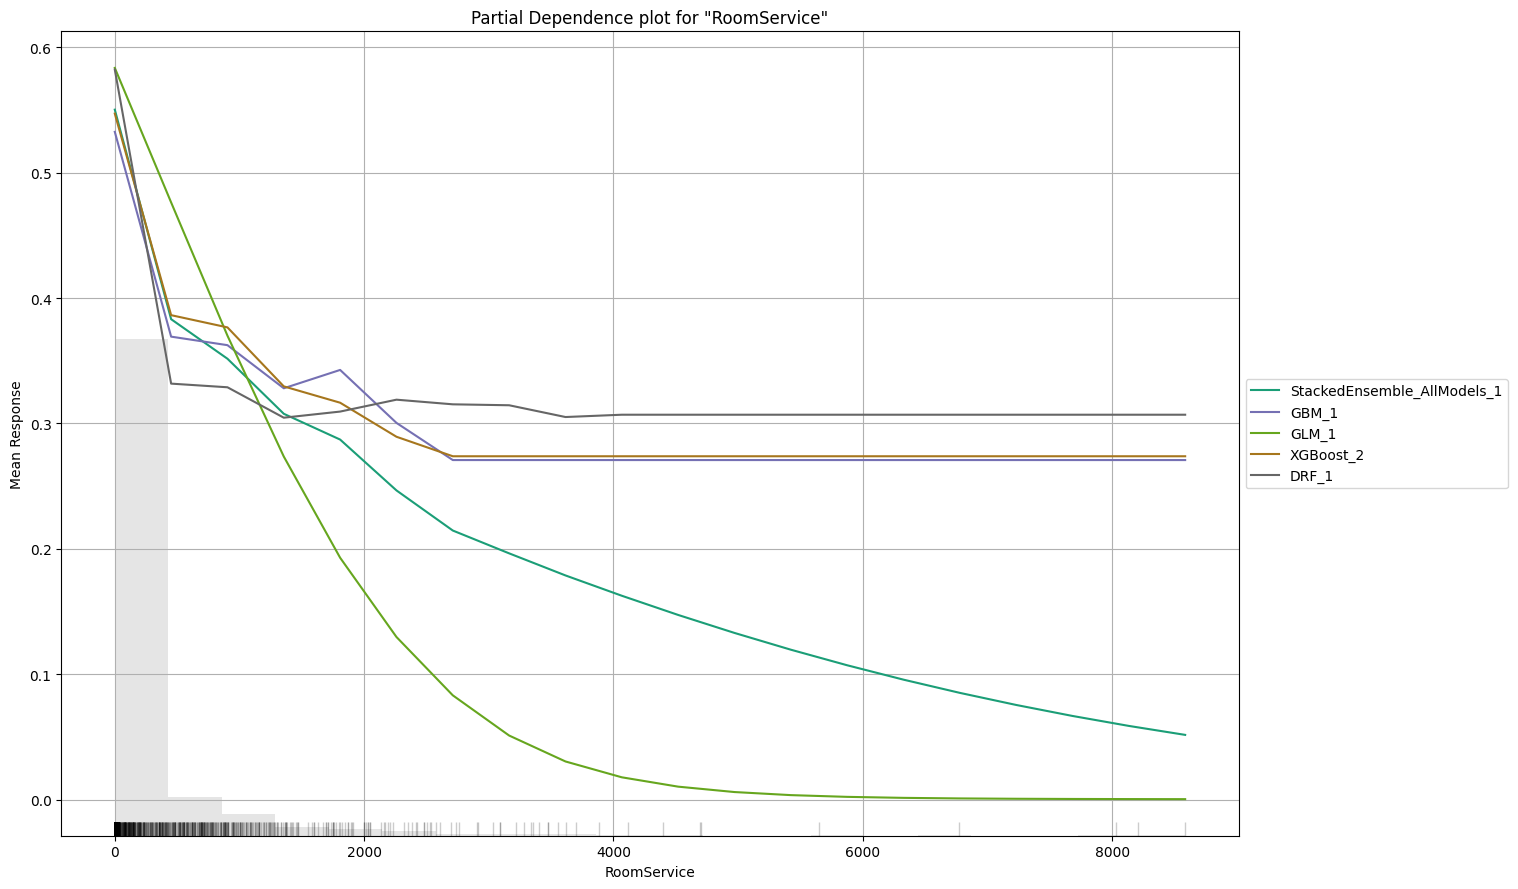

In [127]:
aml.explain(test);

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo,predict,False,True
StackedEnsemble_BestOfFamily_1_AutoML_1_20230531_170128,0.875048,0.442354,0.884473,0.214216,0.38023,0.144575,2442,0.0932,StackedEnsemble,False,0.944854,0.0551456
StackedEnsemble_BestOfFamily_2_AutoML_1_20230531_170128,0.87454,0.440616,0.884127,0.215138,0.379829,0.14427,3369,0.192618,StackedEnsemble,False,0.918842,0.0811578
StackedEnsemble_AllModels_1_AutoML_1_20230531_170128,0.874112,0.439684,0.884263,0.209878,0.379726,0.144192,3064,0.124859,StackedEnsemble,False,0.911181,0.0888187
GBM_1_AutoML_1_20230531_170128,0.866908,0.457988,0.872654,0.220034,0.386076,0.149054,6166,0.117774,GBM,False,0.927223,0.0727766
GBM_3_AutoML_1_20230531_170128,0.865887,0.466497,0.87317,0.211232,0.388182,0.150685,957,0.069012,GBM,False,0.850698,0.149302
GBM_2_AutoML_1_20230531_170128,0.861747,0.497959,0.871848,0.217242,0.400931,0.160746,1076,0.036839,GBM,False,0.749491,0.250509
XGBoost_2_AutoML_1_20230531_170128,0.860017,0.466194,0.870124,0.228467,0.390621,0.152585,795,0.016142,XGBoost,False,0.961632,0.0383681
XGBoost_1_AutoML_1_20230531_170128,0.859587,0.471545,0.871617,0.221802,0.392043,0.153698,2165,0.030258,XGBoost,False,0.989008,0.0109916
GBM_4_AutoML_1_20230531_170128,0.85765,0.503454,0.865728,0.208447,0.403083,0.162476,1063,0.05252,GBM,False,0.737336,0.262664
GLM_1_AutoML_1_20230531_170128,0.855296,0.474503,0.864919,0.232575,0.396854,0.157493,1247,0.023803,GLM,False,0.698195,0.301805


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

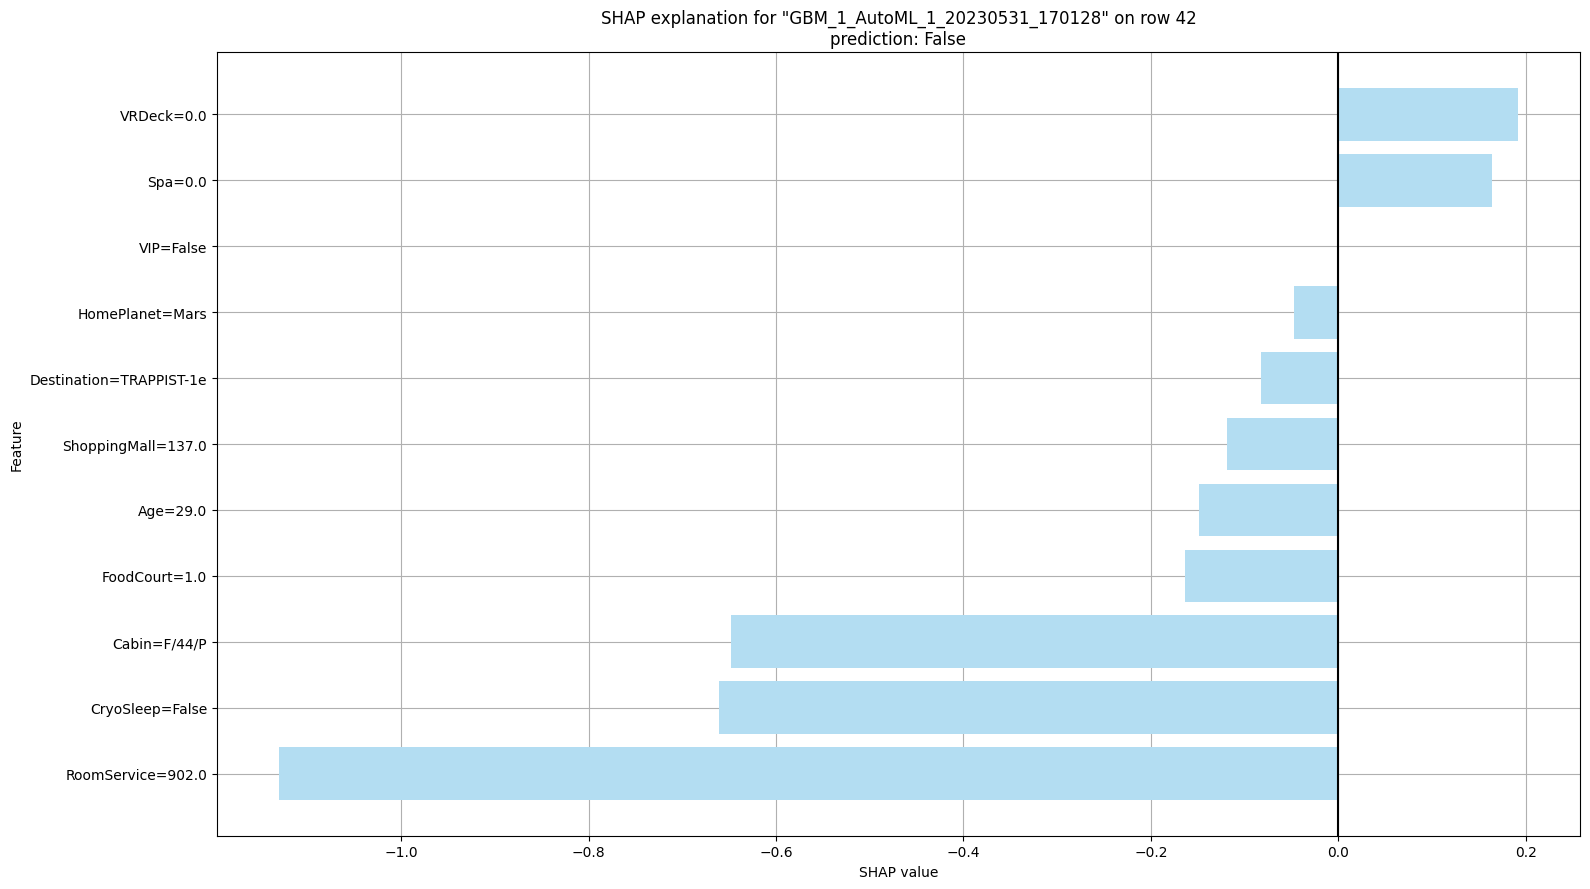

In [128]:
aml.explain_row(test, row_index=42);